In [1]:
import pandas as pd
import numpy as np

from datetime import timedelta, datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import acquire
from acquire import get_items, get_stores, get_sales, get_full_data, get_germany_data
import prepare
from prepare import clean_store, clean_germany

from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
%matplotlib inline

import seaborn as sns
plt.rc('figure', figsize=(13, 7))
# plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('fivethirtyeight')

Use the techniques in the lesson to explore the store item demand dataset and the opsd dataset.

For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. For both datasets you should choose a method of splitting your data and only explore the training split.

### Store Item Demand Dataset

In [2]:
#acquire df
df = get_full_data()

df.head(1)

,Unnamed: 0_x,item,sale_amount,sale_date,sale_id,store,Unnamed: 0_y,store_address,store_city,store_id,store_state,store_zipcode,Unnamed: 0,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
0,0,1,13.00,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013


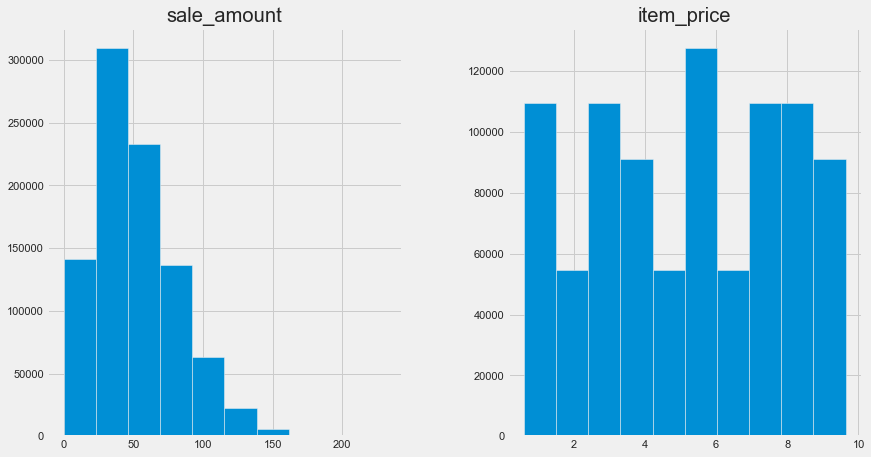

,store_id,item_id,sale_id,sale_amount,item_upc14,item_upc12,item_brand,item_name,item_price,store_address,store_zipcode,store_city,store_state,month,day_of_week,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,1,1,13.00,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,Tuesday,10.92
2013-01-01 00:00:00+00:00,7,12,211817,26.00,74676640211,74676640211,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,12018 Perrin Beitel Rd,78217,San Antonio,TX,1,Tuesday,218.40
2013-01-01 00:00:00+00:00,7,46,832657,27.00,35457770664,35457770664,Mama Marys,Pizza Sauce,4.65,12018 Perrin Beitel Rd,78217,San Antonio,TX,1,Tuesday,125.55
2013-01-01 00:00:00+00:00,8,12,213643,54.00,74676640211,74676640211,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,15000 San Pedro Ave,78232,San Antonio,TX,1,Tuesday,453.60
2013-01-01 00:00:00+00:00,9,12,215469,35.00,74676640211,74676640211,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,735 SW Military Dr,78221,San Antonio,TX,1,Tuesday,294.00


In [3]:
#prepare df
df = clean_store(df)
df.head()

In [4]:
print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

Date Range: 2013-01-01 00:00:00+00:00 to 2017-12-31 00:00:00+00:00
Shape: (913000, 16)


In [5]:
#split data (percentage-based)
#using 70/30 train test split %

train_size = .70
n = df.shape[0] 
test_start_index = round(train_size * n) 
test_start_index #the first 639,100 rows will be set as train

639100

In [6]:
# create train and test dataframe

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

train.shape, test.shape


((639100, 16), (273900, 16))

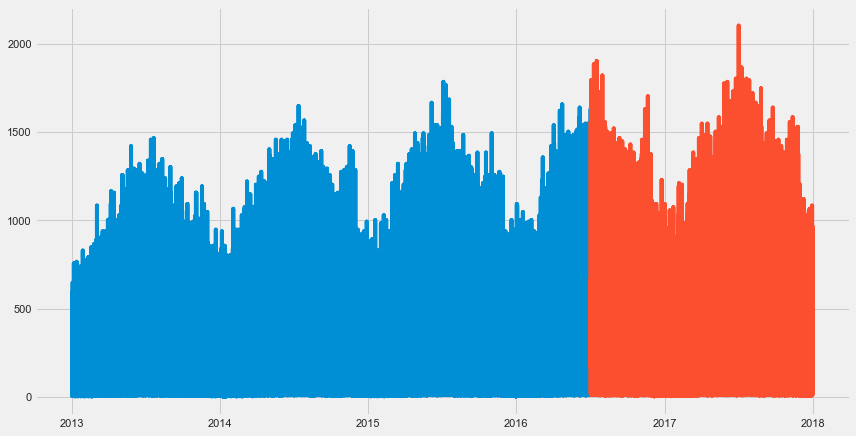

In [7]:
#plot train and test

plt.plot(train.index, train.sales_total) 
plt.plot(test.index, test.sales_total)

In [8]:
# create a series called 'y' 

y = train.sales_total
y.head()

sale_date
2013-01-01 00:00:00+00:00    10.92
2013-01-01 00:00:00+00:00   218.40
2013-01-01 00:00:00+00:00   125.55
2013-01-01 00:00:00+00:00   453.60
2013-01-01 00:00:00+00:00   294.00
Name: sales_total, dtype: float64

<AxesSubplot:ylabel='Frequency'>

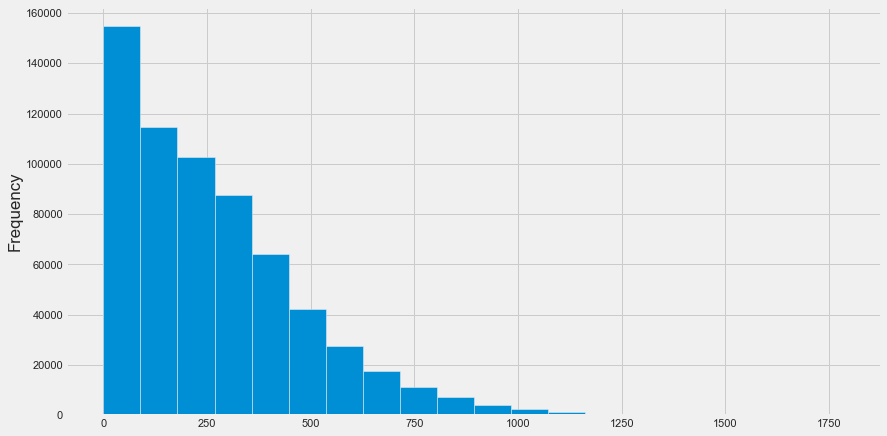

In [9]:
#histogram of sales_total
y.plot.hist(bins=20)

In [10]:
#making a new col for 'year'
train['year'] = y.index.year
train.head()

,store_id,item_id,sale_id,sale_amount,item_upc14,item_upc12,item_brand,item_name,item_price,store_address,store_zipcode,store_city,store_state,month,day_of_week,sales_total,year
sale_date,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,1,1,13.00,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,Tuesday,10.92,2013
2013-01-01 00:00:00+00:00,7,12,211817,26.00,74676640211,74676640211,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,12018 Perrin Beitel Rd,78217,San Antonio,TX,1,Tuesday,218.40,2013
2013-01-01 00:00:00+00:00,7,46,832657,27.00,35457770664,35457770664,Mama Marys,Pizza Sauce,4.65,12018 Perrin Beitel Rd,78217,San Antonio,TX,1,Tuesday,125.55,2013
2013-01-01 00:00:00+00:00,8,12,213643,54.00,74676640211,74676640211,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,15000 San Pedro Ave,78232,San Antonio,TX,1,Tuesday,453.60,2013
2013-01-01 00:00:00+00:00,9,12,215469,35.00,74676640211,74676640211,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,735 SW Military Dr,78221,San Antonio,TX,1,Tuesday,294.00,2013


In [11]:
train.groupby('year').sales_total.mean()

year
2013   233.97
2014   269.11
2015   280.97
2016   291.63
Name: sales_total, dtype: float64

<AxesSubplot:xlabel='year'>

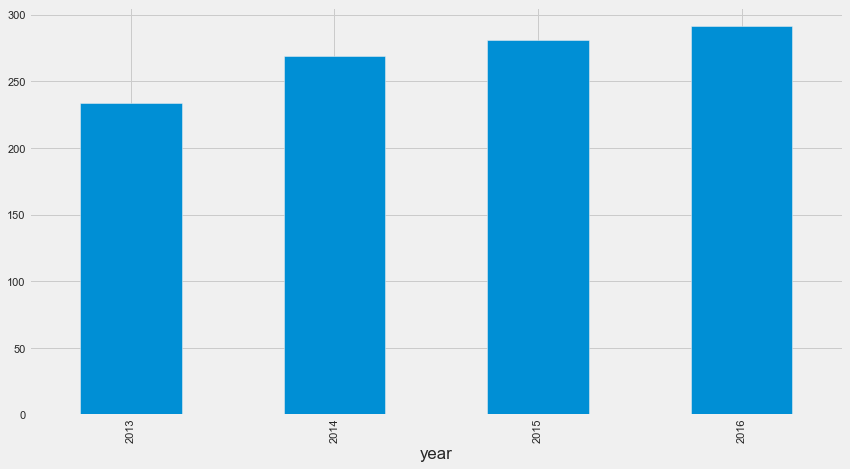

In [12]:
# Plot mean sales by year (bar plot)

train.groupby('year').sales_total.mean().plot.bar()

<AxesSubplot:xlabel='day_of_week'>

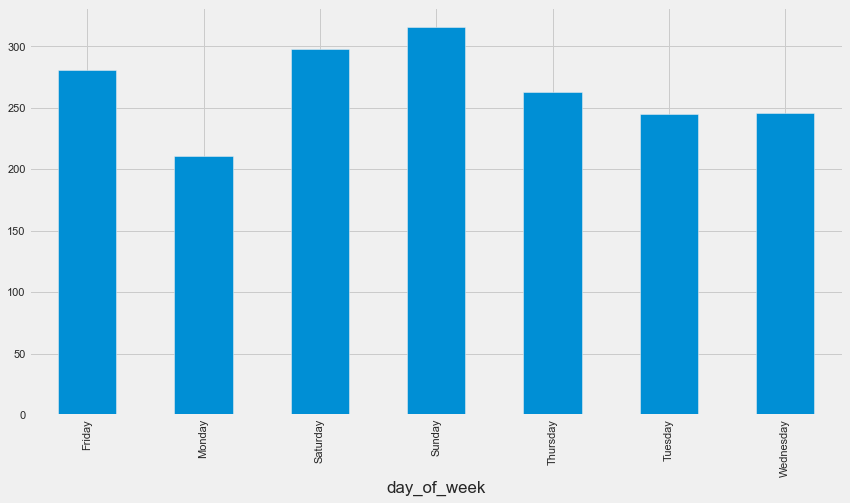

In [13]:
# Plot mean sales by weekday

train.groupby('day_of_week').sales_total.mean().plot.bar()

<AxesSubplot:xlabel='day_of_week', ylabel='sales_total'>

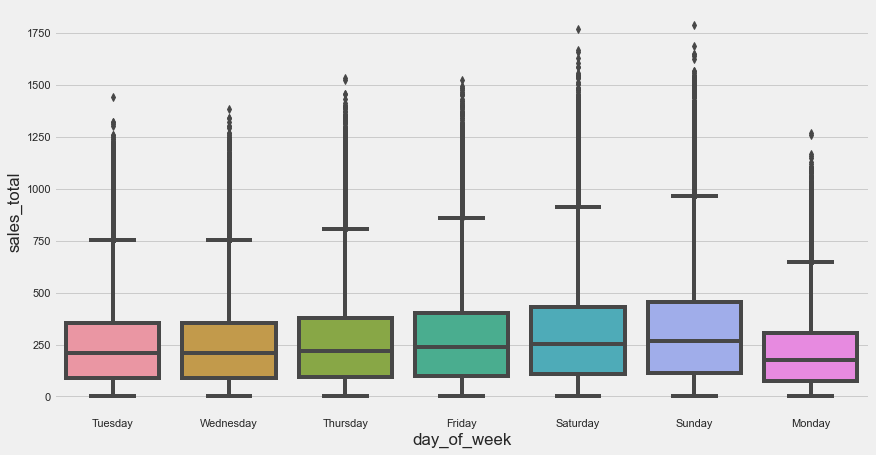

In [14]:
sns.boxplot(data = train, x = 'day_of_week', y = 'sales_total')


In [31]:
# y is the resampled daily data:

y = train.resample('D').sales_total.mean()
y.head()

sale_date
2013-01-01 00:00:00+00:00   147.69
2013-01-02 00:00:00+00:00   147.14
2013-01-03 00:00:00+00:00   156.34
2013-01-04 00:00:00+00:00   168.94
2013-01-05 00:00:00+00:00   175.24
Freq: D, Name: sales_total, dtype: float64

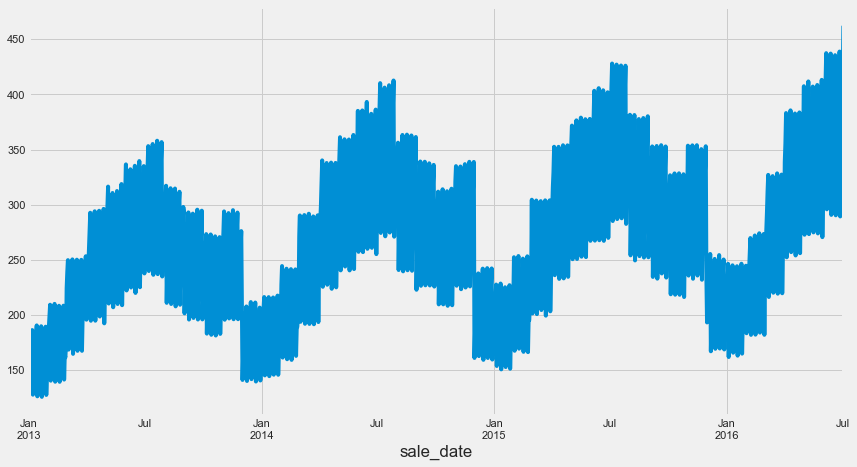

In [23]:
# Plots target variable over time
y.plot()
plt.show()

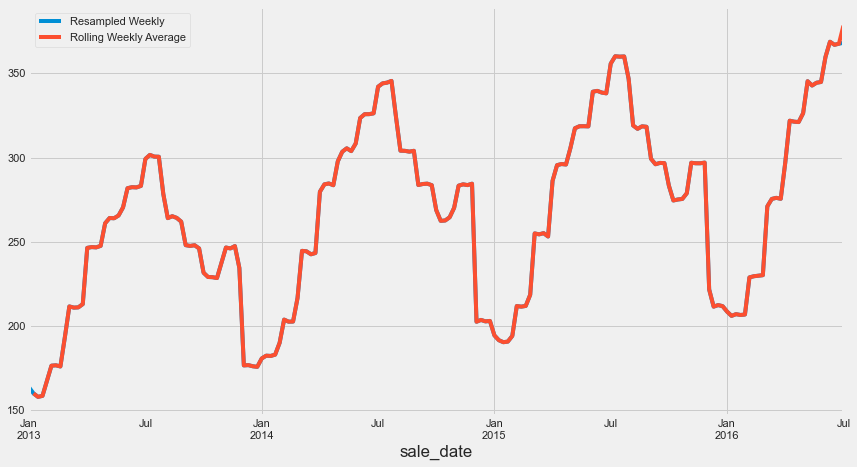

In [32]:
# Plot the weekly average & the 7-day moving average. Compare the 2 plots.

y.resample('W').mean().plot(label='Resampled Weekly')
y.rolling(7).mean().plot(label='Rolling Weekly Average')
plt.legend()

Text(0, 0.5, 'Difference in sales from one day to the next')

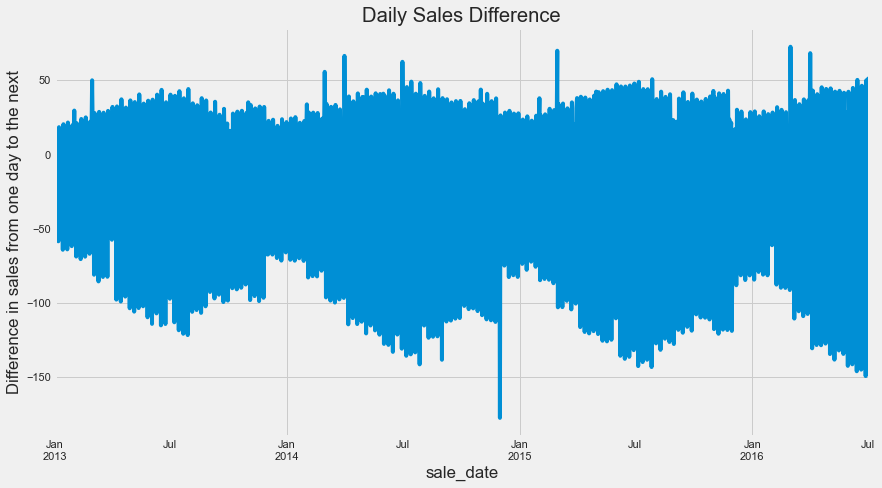

In [17]:
# Plot the daily difference. 
# Observe whether usage seems to vary drastically from day to day or has more of a smooth transition.

y.diff().plot()
plt.title('Daily Sales Difference')
plt.ylabel('Difference in sales from one day to the next')

Text(0, 0.5, '% Change')

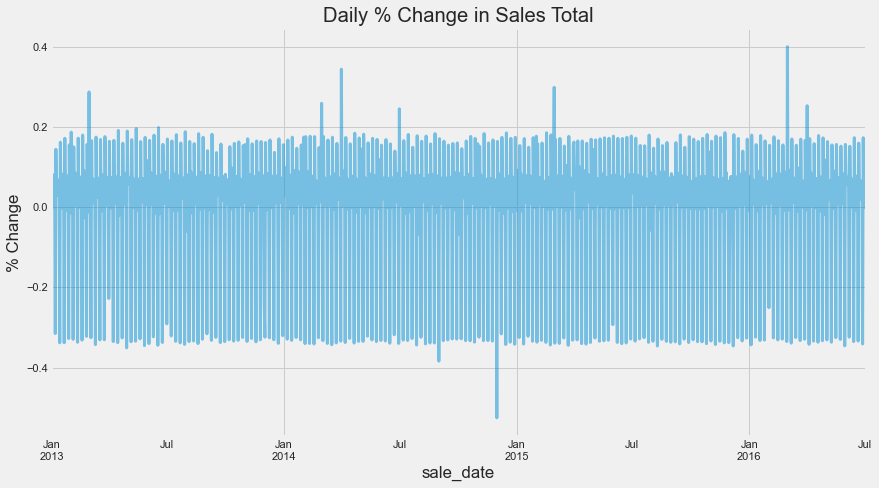

In [18]:
# Maybe it would be helpful to look at percent change as well:

(y.diff() / y.shift()).plot(alpha=.5, lw=3)
plt.title('Daily % Change in Sales Total')
plt.ylabel('% Change')

[Text(0.5, 1.0, 'Monthly % Change in Sales Total')]

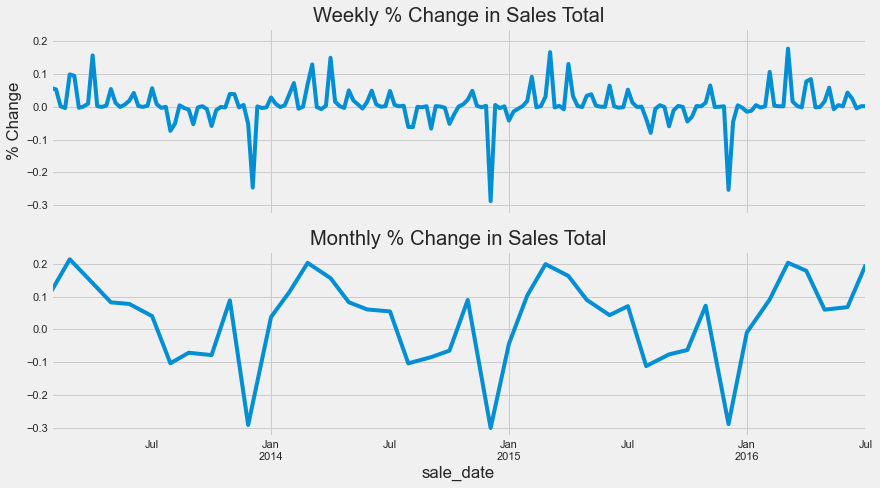

In [19]:
#take a look at this week over week and month over month as well
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

weekly = y.resample('W').mean()
(weekly.diff() / weekly.shift()).plot(ax=ax1)
ax1.set(title='Weekly % Change in Sales Total', ylabel='% Change', xlabel='')

monthly = y.resample('M').mean()
(monthly.diff() / monthly.shift()).plot(ax=ax2)
ax2.set(title='Monthly % Change in Sales Total')
# ax2.hlines(0, *ax2.get_xlim())

In [20]:
y.resample('W').mean()

sale_date
2013-01-06 00:00:00+00:00   163.59
2013-01-13 00:00:00+00:00   159.98
2013-01-20 00:00:00+00:00   157.95
2013-01-27 00:00:00+00:00   158.55
2013-02-03 00:00:00+00:00   167.59
                             ...  
2016-06-05 00:00:00+00:00   359.76
2016-06-12 00:00:00+00:00   368.76
2016-06-19 00:00:00+00:00   366.95
2016-06-26 00:00:00+00:00   367.59
2016-07-03 00:00:00+00:00   368.14
Freq: W-SUN, Name: sales_total, Length: 183, dtype: float64

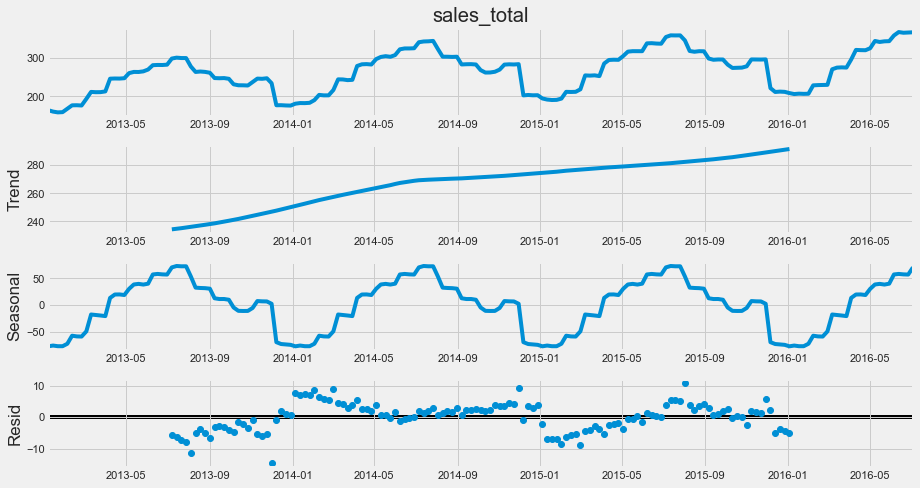

In [21]:
sm.tsa.seasonal_decompose(y.resample('W').mean()).plot()
None

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

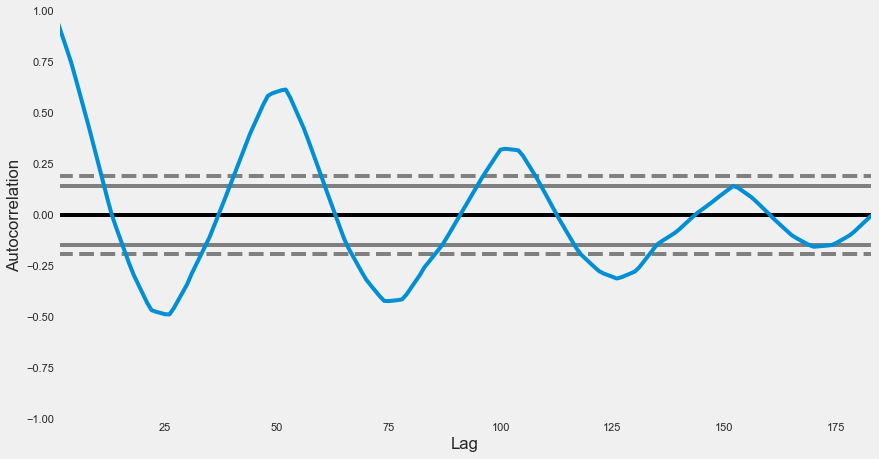

In [22]:
# Autocorrelation after weekly resampling:

pd.plotting.autocorrelation_plot(y.resample('W').mean())

Can see the yearly seasonality in the autocorrelation plot above

### OPSD Dataset

In [34]:
#acquire df
df = get_germany_data()
df.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18,nan,nan,nan
1,2006-01-02,1380.52,nan,nan,nan
2,2006-01-03,1442.53,nan,nan,nan
3,2006-01-04,1457.22,nan,nan,nan
4,2006-01-05,1477.13,nan,nan,nan


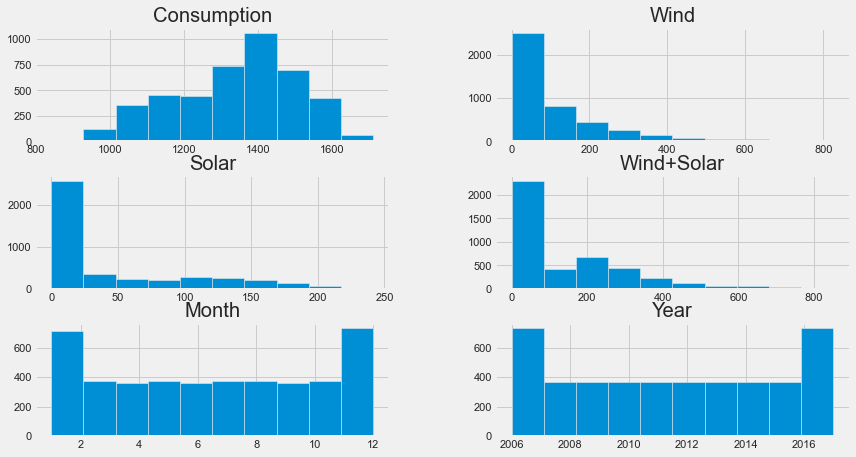

,Consumption,Wind,Solar,Wind+Solar,Month,Year
Date,,,,,,
2006-01-01,1069.18,0.00,0.00,0.00,1,2006
2006-01-02,1380.52,0.00,0.00,0.00,1,2006
2006-01-03,1442.53,0.00,0.00,0.00,1,2006
2006-01-04,1457.22,0.00,0.00,0.00,1,2006
2006-01-05,1477.13,0.00,0.00,0.00,1,2006


In [35]:
#prepared df
df = clean_germany(df)
df.head()

In [37]:
# split the data:
    
train = df[:'2013']
train.head()

,Consumption,Wind,Solar,Wind+Solar,Month,Year
Date,,,,,,
2006-01-01,1069.18,0.00,0.00,0.00,1,2006
2006-01-02,1380.52,0.00,0.00,0.00,1,2006
2006-01-03,1442.53,0.00,0.00,0.00,1,2006
2006-01-04,1457.22,0.00,0.00,0.00,1,2006
2006-01-05,1477.13,0.00,0.00,0.00,1,2006


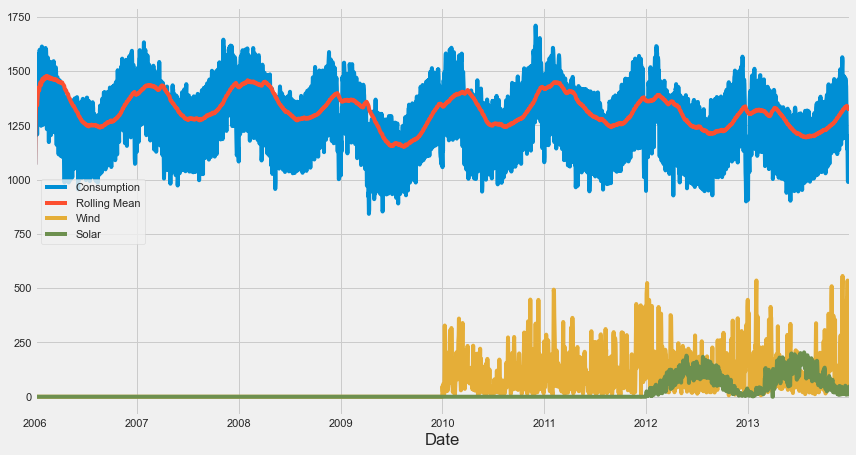

In [39]:
# plot the consumption, wind and solar data

train.Consumption.plot(label="Consumption")
plt.plot(train['Consumption'].rolling('90D').mean(), label="Rolling Mean")
train.Wind.plot()
train.Solar.plot()
plt.legend()

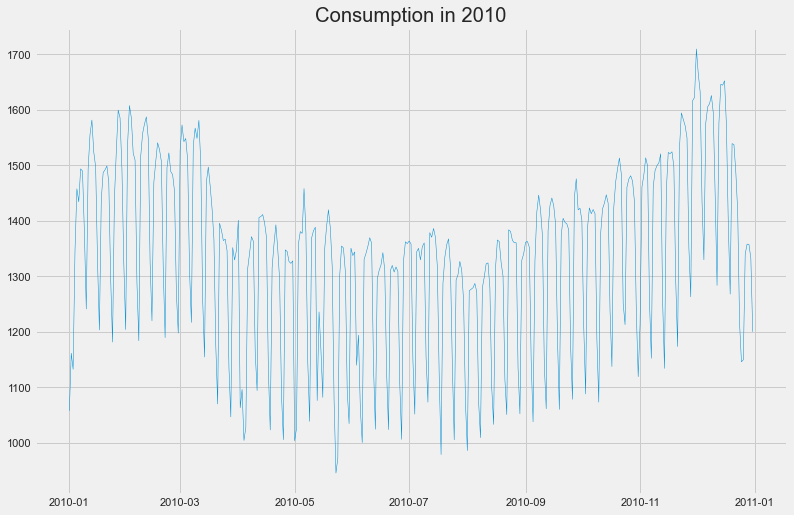

In [40]:
# lets look at consumption in a single year and see if we see any pattern
plt.figure(figsize=(12,8))
plt.plot(train.loc['2010-01':'2010-12']['Consumption'], linewidth = 0.5)
plt.title("Consumption in 2010")
plt.show()

There is a weekly pattern (i.e. within one week) and pattern within weeks of a month

<AxesSubplot:xlabel='Date'>

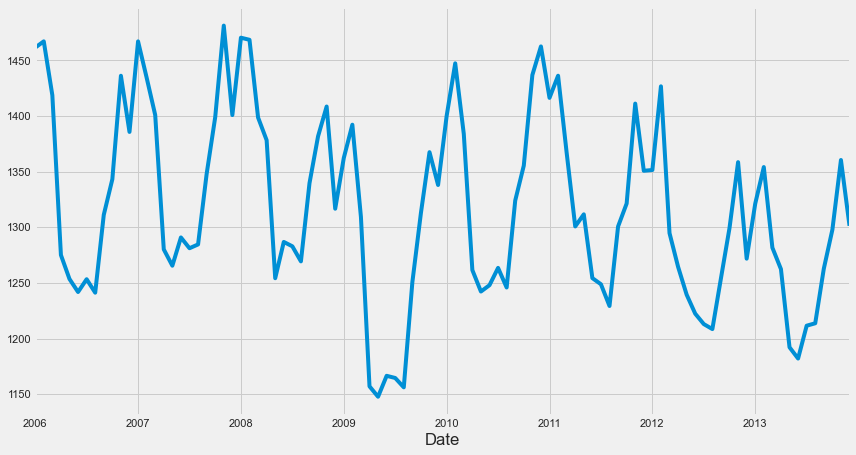

In [41]:
# resample monthly and plot

train.Consumption.resample('M').mean().plot()

(1100.0, 1400.0)

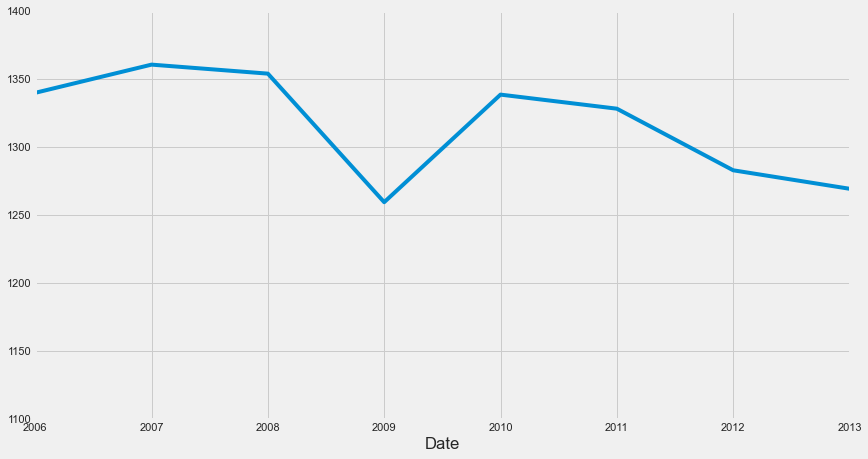

In [42]:
# resample data on yearly basis and plot
train.Consumption.resample('Y').mean().plot()
plt.ylim(1100,1400)

In [43]:
# filling all NaNs with zero
train = train.fillna(0)

In [44]:
# make a new datafrsame sources
sources = train[['Consumption', 'Wind', 'Solar']]

# make a new column called conventional: Consumption - Wind - Solar
sources['Conventional'] = sources.Consumption - sources.Wind - sources.Solar

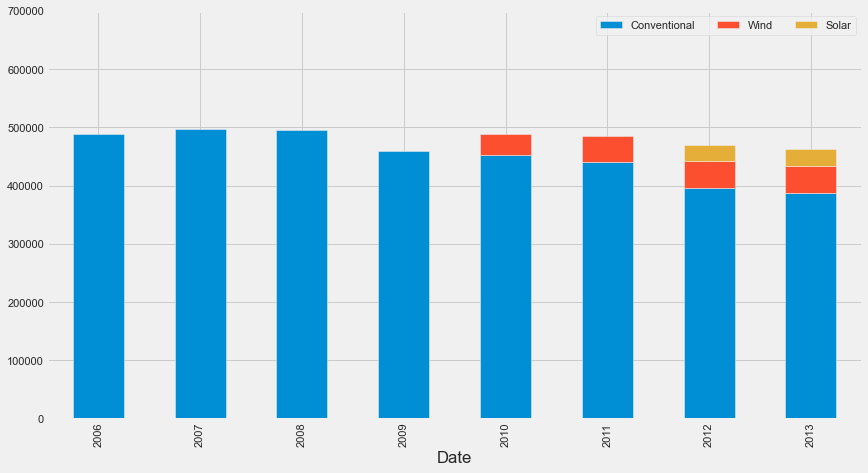

In [45]:
# plot the three power sources as stacked bar chart:

ax = sources[['Conventional', 'Wind', 'Solar']].resample('Y').sum().plot.bar(stacked = True)
ax.set_ylim(0, 700000)
ax.legend(ncol = 3)

labels = [pd.to_datetime(t.get_text()).strftime('%Y') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels);

<AxesSubplot:xlabel='Date'>

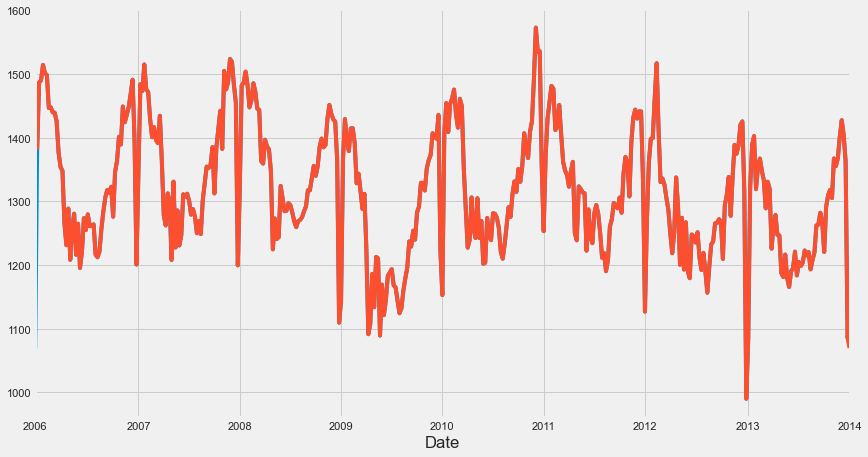

In [46]:
#plot the weekly average and the 7-day moving average and compare the 2 plots
train.Consumption.resample('W').mean().plot()
train.Consumption.rolling(7).mean().plot()

Both of them are almost the same

In [48]:
#group the electricity consumption time sereies by month of year, to explore annual seasonality
train['Month'] = train.index.month
train['Weekday'] = train.index.day_name()

<AxesSubplot:xlabel='Month', ylabel='Consumption'>

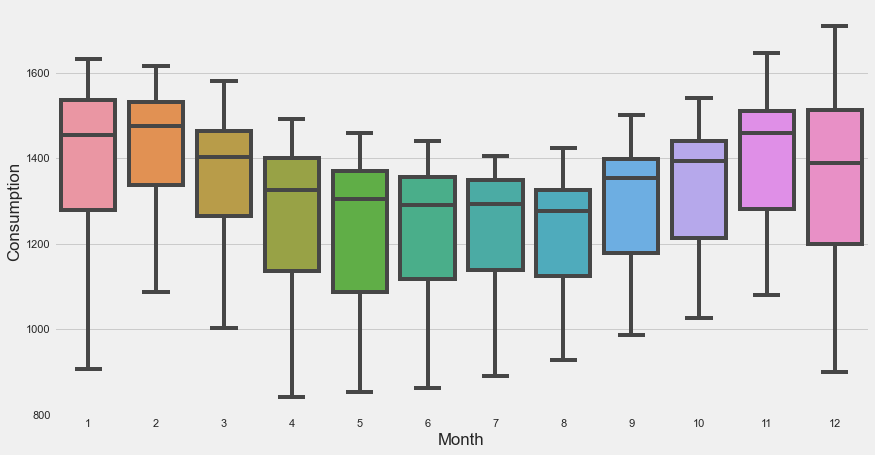

In [49]:
# Energy consumption by month
sns.boxplot(data = train, x = 'Month', y = 'Consumption')

Consumption drops in summer months

<AxesSubplot:xlabel='Weekday', ylabel='Consumption'>

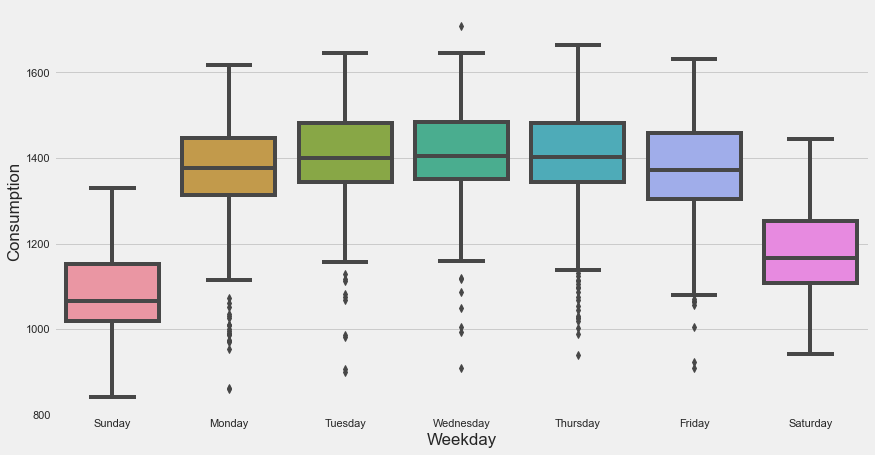

In [52]:
# Energy consumption by weekday
sns.boxplot(data = train, x = 'Weekday', y = 'Consumption')

Seems like consumption drops on the weekends

In [54]:
y = train.Consumption
table = y.groupby([y.index.strftime('%Y'), y.index.strftime('%m-%b')]).mean().unstack(0)

table.head()

Date,2006,2007,2008,2009,2010,2011,2012,2013
Date,,,,,,,,
01-Jan,1461.44,1467.06,1470.37,1362.26,1400.04,1416.29,1351.44,1321.19
02-Feb,1467.11,1434.48,1468.49,1392.16,1447.32,1436.21,1426.67,1354.09
03-Mar,1418.65,1400.91,1398.65,1309.22,1383.87,1366.99,1294.75,1281.67
04-Apr,1275.06,1280.13,1378.24,1157.01,1261.51,1300.73,1264.43,1262.36
05-May,1253.49,1265.44,1254.19,1147.65,1242.22,1311.61,1239.39,1192.12


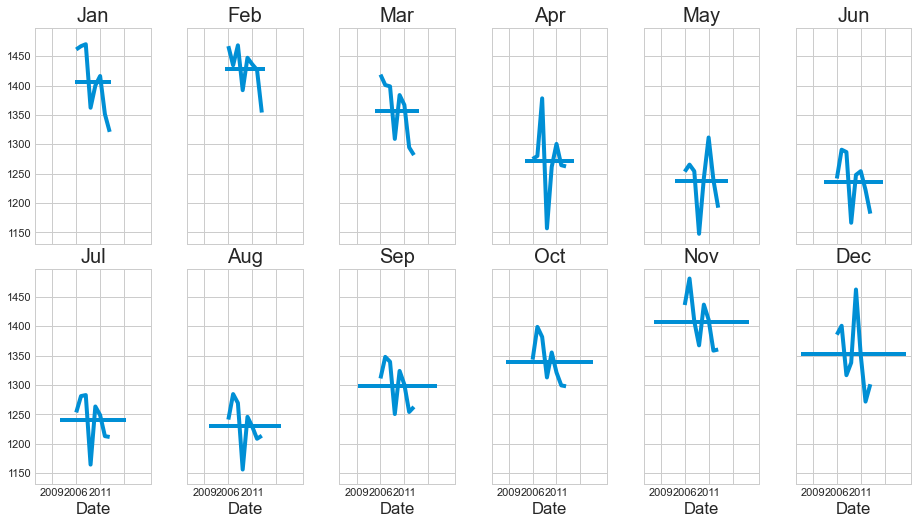

In [55]:
# making a subseasonal plot
with plt.style.context('seaborn-whitegrid'):
    fig, axs = plt.subplots(2, 6, sharex=True, sharey=True)

fig.subplots_adjust(wspace=0)
fig.tight_layout()
for ax, (month, x) in zip(axs.ravel(), table.T.iteritems()):
    x.plot(ax=ax, title=month[3:])
    ax.hlines(x.mean(), *ax.get_xlim())

[Text(0.5, 1.0, 'Wind production pattern')]

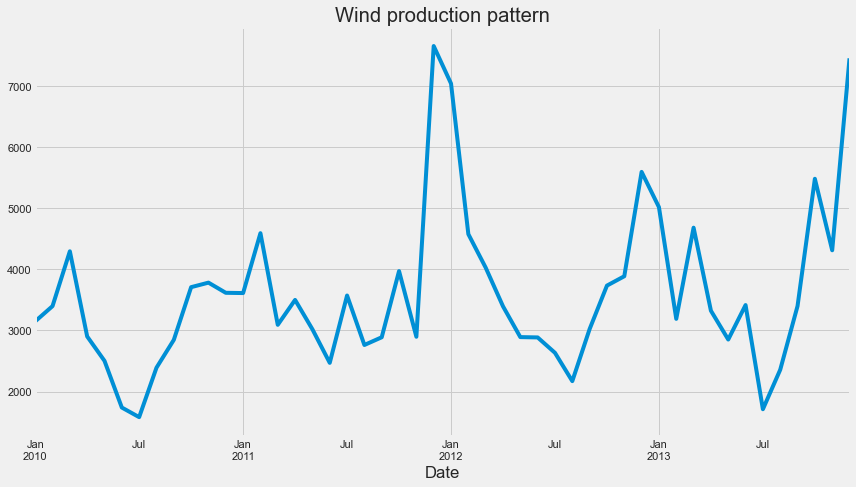

In [56]:
# How does the wind production/consumption vary within a year and also year to year?

ax = train['2010':].Wind.resample('M').sum().plot()
ax.set(title = 'Wind production pattern')

Wind production drops in summer months

[Text(0.5, 1.0, 'Solar production pattern')]

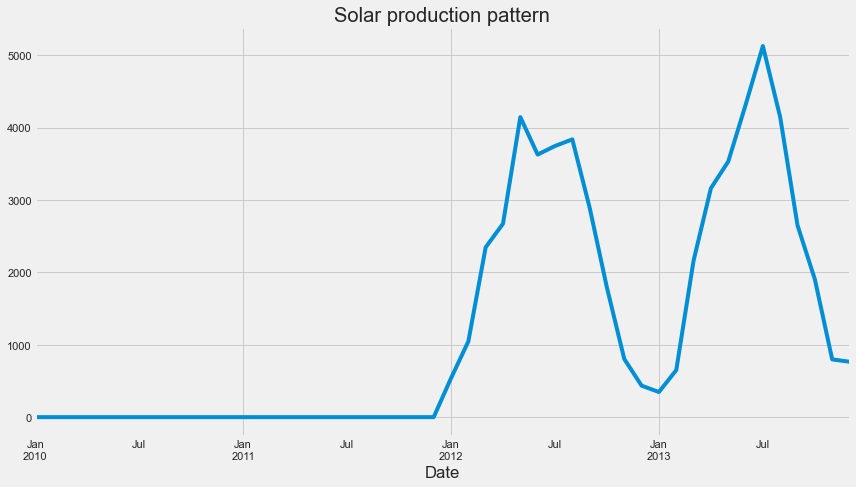

In [58]:
# How does the solar production/consumption vary within a year and also year to year?

ax = train['2010':].Solar.resample('M').sum().plot()
ax.set(title = 'Solar production pattern')

Solar production peaks in the summer

In [59]:
# bring in the GDP growth rate data

growth_rate = {2006:3.815, 2007:2.984, 2008:0.962, 2009:-5.697, 2010:4.179, 2011:3.924, 2012:0.42, 2013:0.428, 2014:2.226 , 2015:1.74 , 2016:2.23 , 2017:2.465 }

In [60]:
# convert dict to dataframe
growth_rate = pd.DataFrame.from_dict(growth_rate, orient='index', columns = ['growth_rate'])
growth_rate.head()

,growth_rate
2006,3.81
2007,2.98
2008,0.96
2009,-5.70
2010,4.18


In [61]:
# set index as datetimeindex
growth_rate.index = pd.to_datetime(growth_rate.index, format = '%Y' )

In [62]:
# check the dataframe hear
growth_rate.head()

,growth_rate
2006-01-01,3.81
2007-01-01,2.98
2008-01-01,0.96
2009-01-01,-5.70
2010-01-01,4.18


Text(0, 0.5, 'Growth Rate')

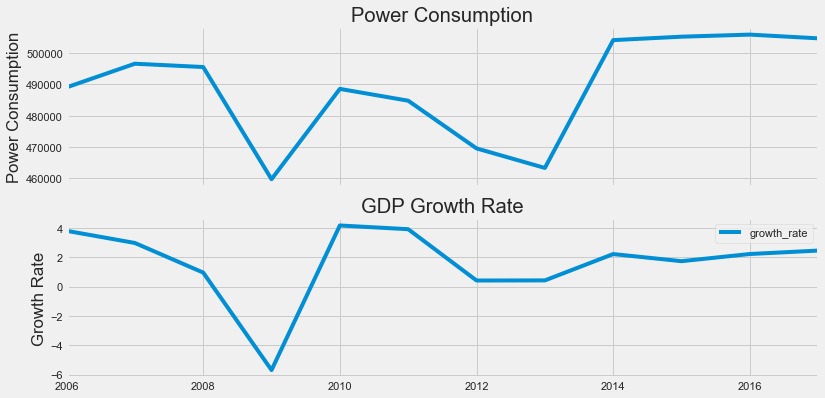

In [64]:
# compare power consumption and GDP growth rate:

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 9))

ax = df.Consumption.resample('Y').sum().plot(figsize = (12,6), ax = ax1)
ax1.set(title='Power Consumption')
ax1.set_ylabel('Power Consumption')

growth_rate.plot(ax =ax2)
ax2.set(title='GDP Growth Rate')
ax2.set_ylabel('Growth Rate')

In [65]:
#time series decomposition
decomposition = sm.tsa.seasonal_decompose(train.resample('W').Consumption.mean(), model='additive')

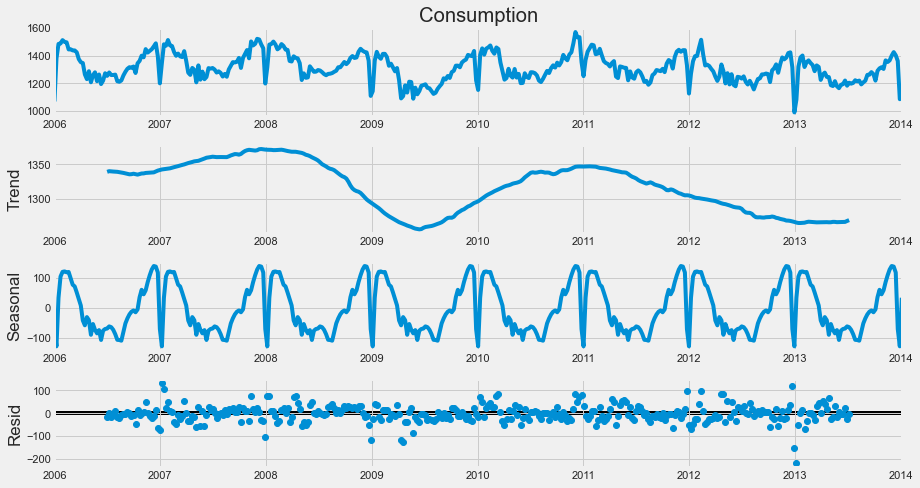

In [66]:
decomposition.plot()
None

There is annual seasonality. The energy consumption drops during December

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

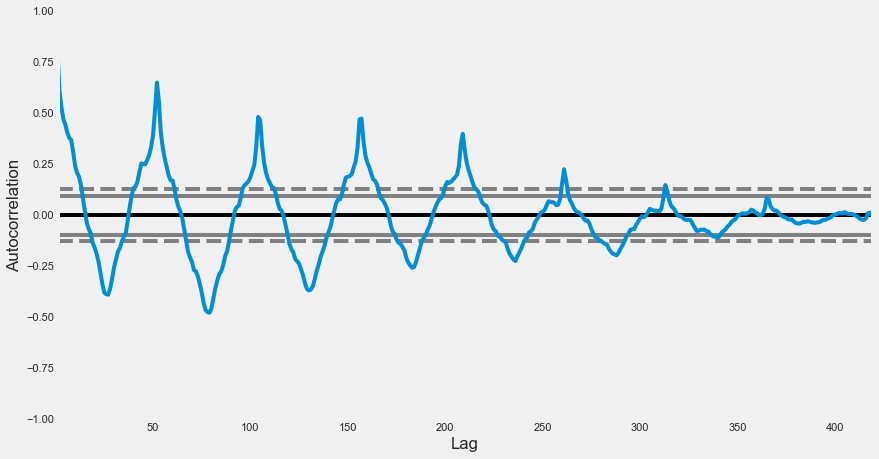

In [67]:
# autocorrelation plot 
pd.plotting.autocorrelation_plot(train.Consumption.resample('W').mean())

Can see then annual pattern in the autocorrelation plot above